In [ ]:
"""
###Exercise
apply transfer learning to create your own CNN to classify images of flowers.
We will provide you with a Colab to guide you through the creation and training of your CNN.
This time you will have to download the Flowers dataset yourself using TensorFlow Datasets and split it into a training and validation set.
"""

In [ ]:
###TensorFlow Hub
"""
TensorFlow Hub is an online repository of already trained TensorFlow models that you can use. These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work.
This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.
"""

In [29]:
###Imports

import tensorflow as tf

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [31]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [32]:
###Ex: Download the Flowers Dataset using TensorFlow Datasets

"""
below you will download the Flowers dataset using TensorFlow Datasets.
If you look at the TensorFlow Datasets documentation you will see that the name of the Flowers dataset is tf_flowers.
You can also see that this dataset is only split into a TRAINING set.
You will therefore have to use tfds.splits to split this training set into to a training_set and a validation_set.
Do a [70, 30] split such that 70 corresponds to the training_set and 30 to the validation_set.
Then load the tf_flowers dataset using tfds.load.
Make sure the tfds.load function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.
"""

(training_set, validation_set), dataset_info = tfds.load(
        'tf_flowers',
        with_info = True,
        as_supervised = True,
        split = ['train[:70%]', 'train[70%:]'],
)


In [41]:
num_classes = dataset_info.features['label'].num_classes

In [34]:
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1
    
for example in validation_set:
    num_validation_examples += 1

In [35]:
###Ex: Print Information about the Flowers Dataset

"""
use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets.
"""

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))


Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [10]:
#The images in the Flowers dataset are not all the same size.

for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [36]:
###Ex: Reformat Images and Create Batches

"""
below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them.
The function should take in an image and a label as arguments and should return the new image and corresponding label.
Then create training and validation batches of size 32.
"""

IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
###Do Simple Transfer Learning with TensorFlow Hub

"""
use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.
"""

###Ex: Create a Feature Extractor

"""
 below create a feature_extractor using MobileNet v2.
 Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector.
 Go to the TensorFlow Hub documentation to see a list of available feature vectors.
 Click on the tf2-preview/mobilenet_v2/feature_vector
 Read the documentation and get the corresponding URL to get the MobileNet v2 feature vector.
 Finally, create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.
"""


In [37]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

feature_extractor = hub.KerasLayer(URL,
                                  input_shape = (IMAGE_RES, IMAGE_RES, 3))

In [38]:
###Ex: Freeze the Pre-Trained Model

#freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

feature_extractor.trainable = False

In [42]:
###Ex: Attach a classification head

"""
below create a tf.keras.Sequential model, and add the pre-trained model and the new classification layer.
Remember that the classification layer must have the same number of classes as our Flowers dataset.
Finally print a summary of the Sequential model.
"""

model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
###Ex: Train the model

"""
bellow train this model like any other, by first calling compile and then followed by fit.
Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.
"""

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 142s 2s/step - loss: 1.0319 - accuracy: 0.5894 - val_loss: 0.4349 - val_accuracy: 0.8492
Epoch 2/6
81/81 [==============================] - 152s 2s/step - loss: 0.3832 - accuracy: 0.8840 - val_loss: 0.3589 - val_accuracy: 0.8747
Epoch 3/6
81/81 [==============================] - 136s 2s/step - loss: 0.3089 - accuracy: 0.9011 - val_loss: 0.3459 - val_accuracy: 0.8819
Epoch 4/6
81/81 [==============================] - 141s 2s/step - loss: 0.2468 - accuracy: 0.9257 - val_loss: 0.2995 - val_accuracy: 0.8974
Epoch 5/6
81/81 [==============================] - 160s 2s/step - loss: 0.2126 - accuracy: 0.9424 - val_loss: 0.2971 - val_accuracy: 0.8946
Epoch 6/6
81/81 [==============================] - 166s 2s/step - loss: 0.1918 - accuracy: 0.9506 - val_loss: 0.2873 - val_accuracy: 0.9019


In [ ]:
"""
we get ~88% validation accuracy with only 6 epochs of training, which is absolutely awesome.
This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training.
The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).
"""

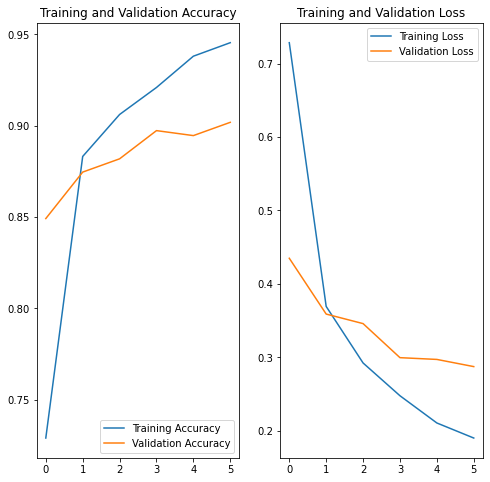

In [44]:
###Ex: Plot Training and Validation Graphs

"""
below, plot the training and validation accuracy/loss graphs.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
"""
validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images.
"""

In [46]:
###Ex: Check Predictions

"""
below get the label names from the dataset info and convert them into a NumPy array.
Print the array to make sure you have the correct label names.
"""

class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [47]:
###Ex: Create an Image Batch and Make Predictions

"""
 below, use the next() function to create an image_batch and its corresponding label_batch.
 Convert both the image_batch and label_batch to numpy arrays using the .numpy() method.
 Then use the .predict() method to run the image batch through your model and make predictions.
 Then use the np.argmax() function to get the indices of the best prediction for each image.
 Finally convert the indices of the best predictions to class names.
"""

image_batch, label_batch =  next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'sunflowers' 'roses' 'dandelion' 'daisy' 'dandelion'
 'sunflowers' 'dandelion' 'daisy' 'tulips' 'tulips' 'roses' 'dandelion'
 'sunflowers' 'daisy' 'daisy' 'daisy' 'sunflowers' 'sunflowers' 'roses'
 'daisy' 'tulips' 'dandelion' 'sunflowers' 'sunflowers' 'tulips'
 'dandelion' 'tulips' 'tulips' 'tulips' 'roses' 'dandelion']


In [48]:
###Ex: Print True Labels and Predicted Indices

"""
below, print the true labels and the indices of predicted labels.
"""

print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 3 4 0 1 0 3 0 0 2 2 4 0 3 1 1 1 3 3 4 1 2 0 3 3 2 0 2 2 2 4 0]
Predicted labels:  [2 3 4 0 1 0 3 0 1 2 2 4 0 3 1 1 1 3 3 4 1 2 0 3 3 2 0 2 2 2 4 0]


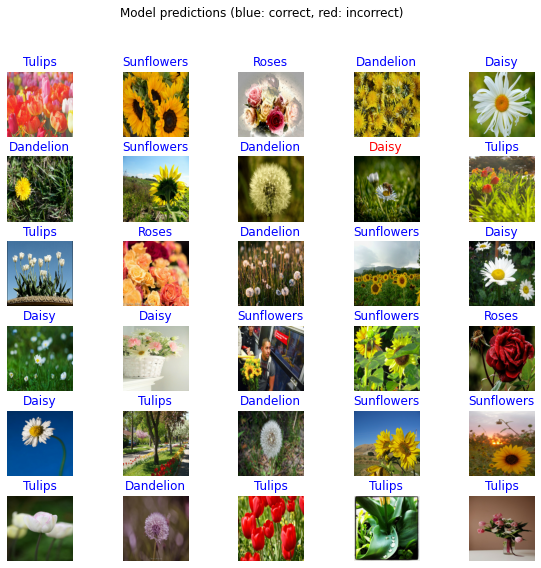

In [49]:
#### Plot Model Predictions

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
###Ex: Perform Transfer Learning with the Inception Model

"""
Go to the TensorFlow Hub documentation and click on tf2-preview/inception_v3/feature_vector.
This feature vector corresponds to the Inception v3 model.
In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset.
Note that Inception, takes as input, images that are 299 x 299 pixels.
Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.
"""

In [50]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [51]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 726s 9s/step - loss: 1.0683 - accuracy: 0.5833 - val_loss: 0.4549 - val_accuracy: 0.8619
Epoch 2/6
81/81 [==============================] - 767s 10s/step - loss: 0.4061 - accuracy: 0.8738 - val_loss: 0.3549 - val_accuracy: 0.8847
Epoch 3/6
81/81 [==============================] - 634s 8s/step - loss: 0.3246 - accuracy: 0.9091 - val_loss: 0.3169 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 634s 8s/step - loss: 0.2714 - accuracy: 0.9212 - val_loss: 0.3081 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 685s 8s/step - loss: 0.2349 - accuracy: 0.9269 - val_loss: 0.2963 - val_accuracy: 0.8992
Epoch 6/6
81/81 [==============================] - 639s 8s/step - loss: 0.2001 - accuracy: 0.9446 - val_loss: 0.2891 - val_accuracy: 0.8983


In [ ]:
##### Summary #####

"""
Transfer Learning to create very powerful Convolutional Neural Networks with very little effort. The main key points of this lesson are:

Transfer Learning: A technique that reuses a model that was created by machine learning experts and that has already been trained on a large dataset. When performing transfer learning we must always change the last layer of the pre-trained model so that it has the same number of classes that we have in the dataset we are working with.
Freezing Parameters: Setting the variables of a pre-trained model to non-trainable. By freezing the parameters, we will ensure that only the variables of the last classification layer get trained, while the variables from the other layers of the pre-trained model are kept the same.
MobileNet: A state-of-the-art convolutional neural network developed by Google that uses a very efficient neural network architecture that minimizes the amount of memory and computational resources needed, while maintaining a high level of accuracy. MobileNet is ideal for mobile devices that have limited memory and computational resources.

You also used transfer learning to create a Convolutional Neural Network that uses MobileNet to classify images of Dogs and Cats. You were able to see that transfer learning greatly improves the accuracy achieved in the Dogs and Cats dataset. As an exercise, you were able to apply everything you learned in this lesson to create your own CNN using MobileNet to classify images of flowers.
"""